In [27]:
#import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow import keras
import seaborn as sn
from sklearn.metrics import confusion_matrix
from tensorflow.keras import layers
import warnings
warnings.filterwarnings('ignore')



In [28]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [29]:
#Read the csv file 
data = pd.read_csv('/content/gdrive/My Drive/fer2013.csv')
data.shape

(35887, 3)

In [30]:
data.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [31]:
#this dictionary em will be used to map different emotions
em = {0:'Angry', 1:'Disgust', 2:'Fear', 3:'Happy', 4:'Sad', 5:'Surprise', 6:'Neutral'}
#Store the different emotions in a list also
target_names = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

In [32]:
data.Usage.value_counts()

Training       28709
PrivateTest     3589
PublicTest      3589
Name: Usage, dtype: int64

In [33]:
#To see how many samples of each emotion are present

newdf = data.groupby('emotion').size()
newdf = pd.DataFrame(newdf)
newdf.insert(0, "Emotion type", target_names, True)
newdf.columns = [ 'Emotion', 'No of samples']
newdf

# newdf.drop('emotion', inplace=True, axis = 1)

,Emotion,No of samples
emotion,,
0,Angry,4953
1,Disgust,547
2,Fear,5121
3,Happy,8989
4,Sad,6077
5,Surprise,4002
6,Neutral,6198


In [34]:
#Separate the training, validation and test data sets
data_train = data[data['Usage'] == 'Training'].copy()
data_val = data[data['Usage'] == 'PublicTest'].copy()
data_test = data[data['Usage'] == 'PrivateTest'].copy()

In [35]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28709 entries, 0 to 28708
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   emotion  28709 non-null  int64 
 1   pixels   28709 non-null  object
 2   Usage    28709 non-null  object
dtypes: int64(1), object(2)
memory usage: 897.2+ KB


In [36]:
#initilize parameters
num_classes = 7 
width, height = 48, 48
num_epochs = 30
batch_size = 32
num_features = 64
input_shape = (width, height, 1)

In [37]:
#this function converts the pixels into a 2D array of size 48x48 and does one-hot encoding for the emotions
from tensorflow.keras.utils import to_categorical
def CRNO(df, dataName):
    df['pixels'] = df['pixels'].apply(lambda pixel_sequence: [int(pixel) for pixel in pixel_sequence.split()])
    data_X = np.array(df['pixels'].tolist(), dtype='float32').reshape(-1,width, height,1)/255.0  
    data_Y = to_categorical(df['emotion'], num_classes)  
    print(dataName, "_X shape: {}, ", dataName, "_Y shape: {}".format(data_X.shape, data_Y.shape)) 
    return data_X, data_Y

    
train_X, train_Y = CRNO(data_train, "train") #training data
val_X, val_Y     = CRNO(data_val, "val") #validation data
test_X, test_Y   = CRNO(data_test, "test") #test data

train _X shape: {},  train _Y shape: (28709, 48, 48, 1)
val _X shape: {},  val _Y shape: (3589, 48, 48, 1)
test _X shape: {},  test _Y shape: (3589, 48, 48, 1)


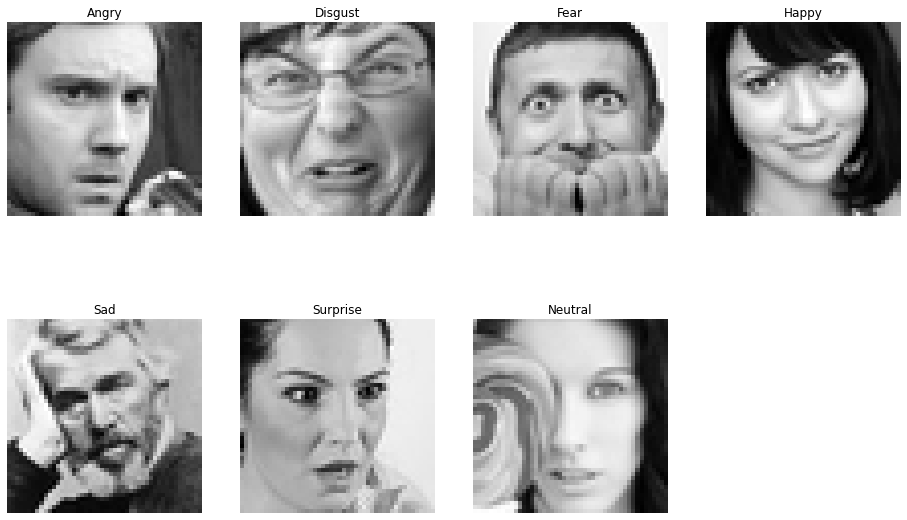

In [39]:
#Let us see some of the images and their target emotions

plt.figure(figsize=(16, 10))

plt.gray()
flag = 0
i= 0
cnt = 0
while cnt < 7:
  if data_train.emotion[i] == cnt:
        cnt = cnt + 1
        plt.subplot(2, 4, cnt)
        plt.imshow(train_X[i].reshape(width, height))
        plt.title(em[data_train.emotion[i]])
        plt.axis('off')    
        #cnt = cnt + 1
  i = i+1
       

plt.show()

In [40]:
from keras.layers.convolutional import Conv2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from keras.layers import Dense, Dropout, Activation, Flatten
model = keras.Sequential()

#Add the different layers to the model


#module 1
model.add(Conv2D(num_features, kernel_size=(3, 3), input_shape=(width, height, 1), data_format='channels_last'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(num_features, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

#module 2
model.add(Conv2D(2*num_features, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(2*num_features, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

#module 3
model.add(Conv2D(2*num_features, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(2*num_features, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(2*num_features, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))


#module 4
model.add(Conv2D(num_features*8, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(num_features*8, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(num_features*8, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

#flatten
model.add(Flatten())

#dense 1
model.add(Dense(64*num_features))
model.add(BatchNormalization())
model.add(Activation('relu'))

#dense 2
model.add(Dense(64*num_features))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Dropout(0.3))

#output layer
model.add(Dense(num_classes, activation='softmax'))





In [41]:
from keras.callbacks import History 
history = History()

In [42]:
#train the model
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
history = model.fit(train_X, train_Y, batch_size=batch_size, epochs=num_epochs, validation_data=(val_X, val_Y))
model.summary()

Epoch 1/30
898/898 [==============================] - 32s 34ms/step - loss: 2.2077 - accuracy: 0.2149 - val_loss: 2.9988 - val_accuracy: 0.1839
Epoch 2/30
898/898 [==============================] - 31s 34ms/step - loss: 2.1360 - accuracy: 0.2342 - val_loss: 2.2447 - val_accuracy: 0.2541
Epoch 3/30
898/898 [==============================] - 31s 35ms/step - loss: 1.9765 - accuracy: 0.2985 - val_loss: 2.2393 - val_accuracy: 0.2218
Epoch 4/30
898/898 [==============================] - 31s 35ms/step - loss: 1.9224 - accuracy: 0.3411 - val_loss: 1.5543 - val_accuracy: 0.3876
Epoch 5/30
898/898 [==============================] - 31s 35ms/step - loss: 1.8384 - accuracy: 0.3816 - val_loss: 3.7454 - val_accuracy: 0.3714
Epoch 6/30
898/898 [==============================] - 32s 35ms/step - loss: 1.7522 - accuracy: 0.4140 - val_loss: 1.5062 - val_accuracy: 0.4051
Epoch 7/30
898/898 [==============================] - 31s 35ms/step - loss: 1.6916 - accuracy: 0.4496 - val_loss: 1.4835 - val_accuracy:

In [43]:
#To check our model's score on validation and test data
score = model.evaluate(val_X, val_Y, verbose = 0)
print("Val loss:", score[0])
print("Val accuracy: ", score[1])

Val loss: 2.4567506313323975
Val accuracy:  0.5895792841911316


In [44]:
score = model.evaluate(test_X, test_Y, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 2.307828664779663
Test accuracy: 0.5879074931144714


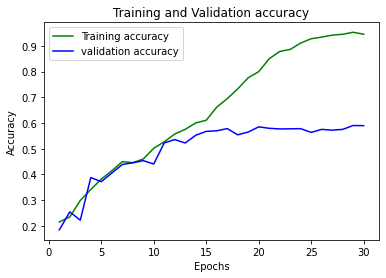

In [48]:
#print(history.history.keys())
loss_train = history.history['accuracy']
loss_val = history.history['val_accuracy']
epochs = range(1, 31)
plt.plot(epochs, loss_train, 'g', label='Training accuracy')
plt.plot(epochs, loss_val, 'b', label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [49]:
predict_prob = model.predict(test_X)
pred = np.argmax(predict_prob,axis=1)
actual = np.argmax(test_Y,axis=1)

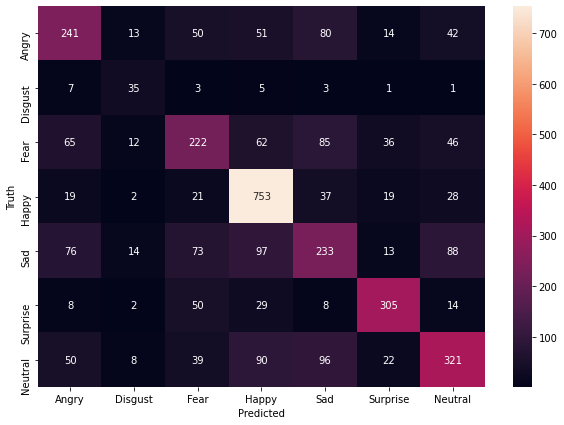

In [50]:
#display confusion matrix
cm = confusion_matrix(data_test.emotion, pred)
df_cm = pd.DataFrame(cm, (emotion for emotion in target_names), (emotion for emotion in target_names))
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

In [51]:
#his code snippet is for displaying the classification report
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
print(classification_report(data_test['emotion'], pred, target_names=target_names, digits=2))


              precision    recall  f1-score   support

       Angry       0.52      0.49      0.50       491
     Disgust       0.41      0.64      0.50        55
        Fear       0.48      0.42      0.45       528
       Happy       0.69      0.86      0.77       879
         Sad       0.43      0.39      0.41       594
    Surprise       0.74      0.73      0.74       416
     Neutral       0.59      0.51      0.55       626

    accuracy                           0.59      3589
   macro avg       0.55      0.58      0.56      3589
weighted avg       0.58      0.59      0.58      3589



In [52]:
# Check Accuracy of each class 

#Normalize the entries
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

#The diagonal entries are the accuracies of each class
cm.diagonal()
d ={'Emotion': target_names, 'Accuracy': cm.diagonal()}
df = pd.DataFrame(d)
df

,Emotion,Accuracy
0,Angry,0.490835
1,Disgust,0.636364
2,Fear,0.420455
3,Happy,0.856655
4,Sad,0.392256
5,Surprise,0.733173
6,Neutral,0.512780
